In [1]:
import numpy as np

from GRAPE import *
import matplotlib.pyplot as plt
from qiskit import Aer, execute

In [2]:
J = np.zeros((3, 3))
J[0][1] = 0.1385
J[1][2] = 0.01304
J[0][2] = 0.00148

CX = np.eye(4)
CX[2][2] = 0
CX[3][3] = 0
CX[2][3] = 1
CX[3][2] = 1

SWAP = np.eye(4)
SWAP[1][1] = 0
SWAP[2][2] = 0
SWAP[1][2] = 1
SWAP[2][1] = 1

TOFFOLI = np.eye(8)
TOFFOLI[6][6] = 0
TOFFOLI[7][7] = 0
TOFFOLI[6][7] = 1
TOFFOLI[7][6] = 1

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)


distance: 0.214339 ; time: 3.57
distance: 0.73159 ; time: 2.97
distance: 0.768828 ; time: 2.58
distance: 0.405057 ; time: 2.92
distance: 0.259197 ; time: 2.73
distance: 0.268662 ; time: 3.17
distance: 0.129121 ; time: 3.58
distance: 0.797163 ; time: 2.37
distance: 0.548256 ; time: 3.07
distance: 1.328623 ; time: 2.51


C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  evolution = evolution @ (math.cos(math.pi / 2 * self.J[i][j] * self.time) * np.eye(2 ** self.size,
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  dtype=complex) - 1j * math.sin(


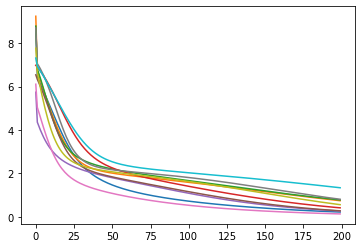

In [3]:
n = 10
m = 200
k = 4

descents = [GradientDescend(CX, k) for _ in range(n)]

for descent in descents:
    descent.noise = 0.05
    descent.randomize_params()
    descent.set_j(J)

losses = [descent.descend(steps=m, track_distance=True) for descent in descents]

for loss in losses:
    plt.plot(np.real(loss))
for descent in descents:
    descent.make_times_positive()
    print("distance:", descent.distance.round(6).real, "; time:", descent.time.round(2))


In [4]:
descent = descents[7]

In [7]:
descent.descend(1000)

C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix = math.cos(self.params[0] / 2) * self._id - 1j * math.sin(self.params[0] / 2) * (
C:\Users\Panfe\PycharmProjects\GRAPE\GRAPE.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  math.cos(self.params[1]) * self._x + math.sin(self.params[1]) * self._y)


In [8]:
descent.distance

(0.0008212400622674516+0j)

In [10]:
descent.make_times_positive()

In [12]:
descent.to_device_text("CX.txt")